# Plots
## Accuracy für KNN 

In [2]:
import numpy as np
import pandas as pnd
import sklearn
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc
from functions.KNN import*

In [4]:
import csv
import seaborn as sns
from scipy import spatial
from scipy.spatial import KDTree
from collections import Counter
from scipy.stats import mode
from functions.PCA import pca
from pathlib import Path
import matplotlib.pyplot as plt
import os
import timeit
from itertools import cycle
from collections import Counter
from scipy.stats import mode
from scipy import spatial
import glob



dataset = 1
match dataset:
    case 1:
        test = 'fashion-mnist_test.csv'
        train = 'fashion-mnist_train.csv'
    case 2: 
        test = "mnist_test.csv"
        train = "mnist_train.csv"
testdata = pnd.read_csv(test)
traindata = pnd.read_csv(train)

testdata_pixel = testdata.drop(testdata.columns[0], axis=1).to_numpy()
traindata_pixel = traindata.drop(traindata.columns[0], axis=1).to_numpy()
label_train = traindata[traindata.columns[0]].to_numpy()
label_test = testdata[testdata.columns[0]].to_numpy()


PCs_train, PCs_test = pca(traindata_pixel,testdata_pixel,0.95)

class_names = np.array(["T-shirt / Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])

folder_path = 'Results/'  # Path to the "results" folder
csv_filess = glob.glob(folder_path + '/*.csv')


totallist = []
for csvdata in csv_filess:
    df = pnd.read_csv(csvdata)
    for i in range(14):
        accuracy = np.sum(df.iloc[:,i] == label_test)/ len(label_test)
        totallist.append(accuracy)
varvec = [0.25,0.5,0.75,0.8,0.85,0.9,0.95,1]
pclist = [i for i in varvec for _ in range(14)]
klist = [i for _ in range(8) for i in range(2,16)]
totallist = pnd.DataFrame({"number of k":klist,"accuracy":totallist,"explained variance":pnd.Categorical(pclist, ordered=True)})

palette = sns.color_palette('viridis', len(totallist['explained variance'].unique()))
variancepcsks = sns.relplot(
data=totallist,
x = 'number of k',
y= 'accuracy',
hue = 'explained variance',
palette = palette
)
plt.axhline(y=0.9085,color="green",linewidth=2),
plt.text(x=totallist['number of k'].max()+0.8, y=0.9085, s='lenet5-inspired cnn', color='green')
plt.axhline(y=0.9221,color="darkgreen",linewidth=2),
plt.text(x=totallist['number of k'].max()+0.8, y=0.9221, s='vgg-inspired cnn', color='darkgreen')
#plt.savefig('projectsummary.png',dpi=600) 

(784, 784)
Our eigenvectors explain 95.02224534091702 percent of total variance
256 eigenvectors are used


ValueError: ('Lengths must match to compare', (14,), (10000,))

<AxesSubplot:>

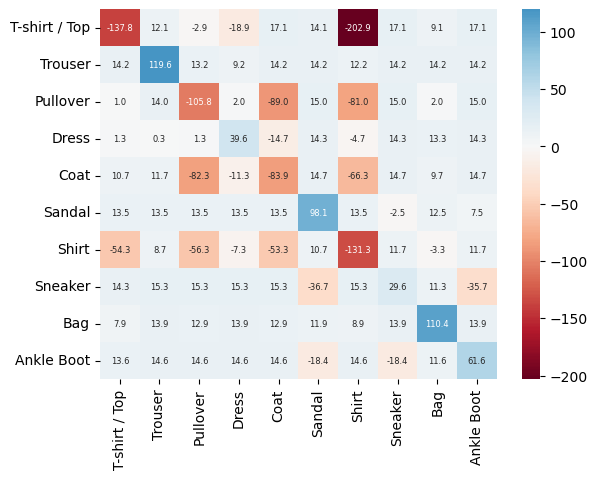

In [5]:
y_pred = pnd.read_csv("./Results/95var.csv").iloc[:,2]
conf = sklearn.metrics.confusion_matrix(y_pred, label_test)
conf_df = pnd.DataFrame(conf, index=class_names, columns=class_names)
conf_df = conf_df.astype(float)
rowsums = conf_df.sum(axis=1)
acc = np.sum(y_pred == label_test)/ len(label_test)
for i in range(len(conf_df)):
    for j in range(len(conf_df.columns)):
        if i != j:
            conf_df.values[i,j] -= (1-acc)*rowsums[i]/(len(conf_df)-1)
            conf_df.values[i,j] *= -1
        else: 
            conf_df.values[i,j] -= acc*rowsums[i]
sns.heatmap(conf_df, annot=True, cmap= "RdBu", annot_kws={"fontsize":6},fmt=",.1f",center=0)
#plt.savefig('knn_chi.png',dpi=600)

In [6]:
# Confusion Matrix vor k = 4 and PC Variance 95%
dftest = pnd.read_csv('C:/Users/awark/Bioinfo Projekt/Results/95var.csv')
y_pred = np.array(dftest['2'])
y_true = label_test
class_names = np.array(["T-shirt / Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
conf = sklearn.metrics.confusion_marix(y_pred, label_test)
conf_df = pnd.DataFrame(conf, index=class_names, columns=class_names)
conf_df = round(conf_df*100 / conf_df.sum(axis=1),2)
print(conf_df)

sns.heatmap(conf_df, annot=True, cmap='RdYlGn')

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/awark/Bioinfo Projekt/Results/95var.csv'

In [7]:
listprec = []
listrec = []
listfscore = []

for csvdata in csv_filess:
    dfmeasures = pnd.read_csv(csvdata)
    for i in range(14):
        ytrue=label_test
        ypred = dfmeasures.iloc[4]
        prf = sklearn.metrics.precision_recall_fscore_support(ytrue, ypred, average=None, labels=label_test)
        precision=prf[0]
        recall=prf[1]
        fscore=prf[2]       
        listprec.append(precision)
        listrec.append(recall)
        listfscore.append(fscore)

listprec95 = []
listrec95 = []
listfscore95 = []
listprec95avg = []

dfmeasures_95var = pnd.read_csv('C:/Users/awark/Bioinfo Projekt/Results/95var.csv')
for i in range(14):
    ypred=dfmeasures['2']
    ytrue = label_test
    prf95=sklearn.metrics.precision_recall_fscore_support(ytrue, ypred, average=None, labels=label_test)
    prf95avg=sklearn.metrics.average_precision_score(ytrue, ypred)
    precision95 = prf95[0]
    recall95 = prf95[1]
    fscore95 = prf95[2]
    listprec95.append(precision)
    listrec95.append(recall)
    listfscore95.append(fscore)


        


NameError: name 'csv_filess' is not defined

Timeit Befehl: KNN kdtrees gegen KNN

In [8]:
def knn_kdtree(PCs_train, PCs_test, k, label_train, label_test, testsize):
    """returns the accuray of the KNN for test images

    Args:
        PCs_train (numpy array): transformed training data
        PCs_test (numpy array): transformed testing data
        k (int): number of neighbours 
        label_train (numpy array 1D): labels of training data
        label_test (numpy array 1D): labels of testing data
        testsize (int): number of testing images you want to classify
        
    Returns:
        knn for number of testsize images
    """

    result = np.array([])
    kd_tree = spatial.KDTree(PCs_train,leafsize=10)
    count_count = 0
    for i in range(0, len(label_test), testsize):
        if count_count % 10 == 0:
            print("Current progress is " + str(count_count*100/(len(label_test)/testsize)) + " percent.")
        count_count += 1
        dist, neighbour_index = kd_tree.query(PCs_test[i:i+testsize, None],p=2,k=k, workers = -1)
        neighbour_label = label_train[neighbour_index]
        batch_result = [mode(neighbour_label,axis=2)[0]]
        batch_result = np.array(batch_result)
        batch_result = np.squeeze(batch_result)
        batch_result = batch_result.astype(int)
        result = result.astype(int)
        result = np.concatenate((result, batch_result), axis=0)
    return result

knn_kdtree(PCs_test, PCs_test, 4, label_train, label_test, 50)

knn_kdtree_timeit = timeit.timeit('"-".join(str(n) for n in range(100))', number=1000000)

### 1,10,20,50,100


NameError: name 'PCs_test' is not defined

In [9]:
knn_quality(PCs_train, PCs_test, 4, label_train, label_test, 50)
timeit_knnquality = timeit.timeit('"-".join(str(n) for n in range(100))', number=1000000) 

NameError: name 'PCs_train' is not defined

In [10]:
def knn_kdtree_mod(PCs_train, PCs_test, k, label_train, label_test, testsize, leafsize):
    """returns the accuray of the KNN for test images

    Args:
        PCs_train (numpy array): transformed training data
        PCs_test (numpy array): transformed testing data
        k (int): number of neighbours 
        label_train (numpy array 1D): labels of training data
        label_test (numpy array 1D): labels of testing data
        testsize (int): number of testing images you want to classify
        
    Returns:
        knn for number of testsize images
    """

    result = np.array([])
    kd_tree = spatial.KDTree(PCs_train,leafsize)
    count_count = 0
    for i in range(0, len(label_test), testsize):
        if count_count % 10 == 0:
            print("Current progress is " + str(count_count*100/(len(label_test)/testsize)) + " percent.")
        count_count += 1
        dist, neighbour_index = kd_tree.query(PCs_test[i:i+testsize, None],p=2,k=k, workers = -1)
        neighbour_label = label_train[neighbour_index]
        batch_result = [mode(neighbour_label,axis=2)[0]]
        batch_result = np.array(batch_result)
        batch_result = np.squeeze(batch_result)
        batch_result = batch_result.astype(int)
        result = result.astype(int)
        result = np.concatenate((result, batch_result), axis=0)
    return result

timeit.timeit('"-".join(str(n) for n in range(100))', number=1000000)

timeit_leafsize = []
leafsizes = np.array([1, 10, 20, 50, 100])
for i in leafsizes:
    knn_kdtree_mod(PCs_train, PCs_test, 4, label_train, label_test, 50, i)
    timeit_leafsize.append(timeit.timeit('"-".join(str(n) for n in range(100))', number=1000000))



NameError: name 'PCs_train' is not defined

In [ ]:
timeit = pnd.DataFrame(timeit_leafsize, index=(['1', '10', '20', '50', '100']),columns=(['timeit']))
print(timeit)



NameError: name 'timeit_leafsize' is not defined

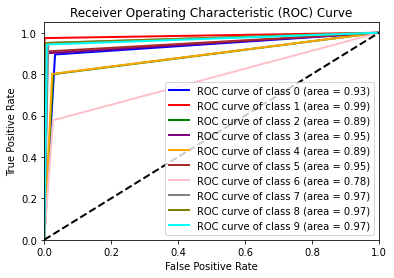

In [ ]:
# ROC curve in Python
n_classes = 10
dfmeasures_95var = pnd.read_csv('C:/Users/awark/Bioinfo Projekt/Results/95var.csv')
ypred = np.array(label_binarize(dfmeasures_95var['2'], classes=range(n_classes)))

y_bin = label_binarize(label_test, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], np.array(ypred[:, i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc.png', dpi=600)
plt.show()


